# Data Preparation, Cleaning and Exploratory Data Analysis


## Data Preparation


#### I will be using the [EuroParl Dataset](http://www.statmt.org/europarl/) for the purpose of Language Classification

The data is in files and folders format where in the folder names are to be used as the labels for the data and each file in the folder represents a row of text.

In this notebook I'll extract the text data from each folder and transform it into DataFrames to be used in other notebooks for Exploratory Data Analysis and Machine Learning.

We have a total of 21 different languages in the dataset on which I would be performing Multi-Class Classification.

### The languages are as follows:
* Romanic (French, Italian, Spanish, Portuguese, Romanian), 
* Germanic (English, Dutch, German, Danish, Swedish)
* Slavik (Bulgarian, Czech, Polish, Slovak, Slovene)
* Finni-Ugric (Finnish, Hungarian, Estonian)
* Baltic (Latvian, Lithuanian)
* Greek

In [1]:
import os
import codecs
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk import FreqDist

In [2]:
full_df = pd.DataFrame(columns = ['text', 'label'])

langList = []
path = './txt/'

for name in os.listdir(path):
    if len(name) == 2:
        langList.append(name)

for label, lang in enumerate(langList):
    df = pd.DataFrame(columns = ['text', 'label'])
    text_list = []
    
    for filename in os.listdir(path+lang+"/"):
        with codecs.open(path+lang+"/"+filename, "r", encoding='utf-8', errors='ignore') as fdata:
            lines = ''
            for line in fdata:                
                if line[0] == '<':
                    continue
                lines += line
                
            text_list.append(lines)    
            
            
    df['text'] = text_list
    df['label'] = lang
    
    df = df[df.text[:] != '']
    
    full_df = pd.concat([full_df,df])
    
    df.to_csv(path+'%s.csv' %lang, index=False)
    print('Completed %s..' %lang)
    
full_df.to_csv(path+'europarl.csv', index=False)
print('Completed.')

Completed bg..
Completed cs..
Completed da..
Completed de..
Completed el..
Completed en..
Completed es..
Completed et..
Completed fi..
Completed fr..
Completed hu..
Completed it..
Completed lt..
Completed lv..
Completed nl..
Completed pl..
Completed pt..
Completed ro..
Completed sk..
Completed sl..
Completed sv..
Completed.


### After completing with the extraction of all the Texts into a DataFrame we can perform some Exploratory Data Analysis to gain some insights about the Dataset.

In [3]:
df = pd.read_csv('./txt/europarl.csv')
df.head()

,text,label
0,състав на парламента вж протоколи,bg
1,одобряване на протокола от предишното заседани...,bg
2,състав на парламента вж протоколи,bg
3,проверка на пълномощията вж протоколи,bg
4,внасяне на документи вж протоколи,bg


In [4]:
pd.set_option('display.max_columns', 21)
df.groupby('label').count().T

label,bg,cs,da,de,el,en,es,et,fi,fr,hu,it,lt,lv,nl,pl,pt,ro,sk,sl,sv
text,6584,8842,9373,9224,9271,9672,9433,8819,9335,9450,8763,9486,8819,8787,9433,8821,9434,6571,8804,8742,9402


###### As we can see from the above cell, the data is almost properly distributed within all the cells, hence we don't have to modify it.

## Getting Test Data

In [5]:
test_df = pd.read_csv('./test/europarl.test', sep='\t', names=['label', 'text'])
test_df = test_df[['text', 'label']]
test_df.to_csv('./test/europarl_test.csv', index=False)

In [6]:
test_df = pd.read_csv('./test/europarl_test.csv')
test_df.head()

,text,label
0,Европа 2020 не трябва да стартира нов конкурен...,bg
1,(CS) Най-голямата несправедливост на сегашната...,bg
2,"(DE) Г-жо председател, г-н член на Комисията, ...",bg
3,"(DE) Г-н председател, бих искал да започна с к...",bg
4,"(DE) Г-н председател, въпросът за правата на ч...",bg


In [7]:
test_df.groupby('label').count().T

label,bg,cs,da,de,el,en,es,et,fi,fr,hu,it,lt,lv,nl,pl,pt,ro,sk,sl,sv
text,1000,1000,1000,1000,992,1000,1000,1000,1000,1000,1000,1000,1000,979,1000,1000,1000,928,929,1000,1000


###### The Text Dataset is perfectly normalized and hence no modifying would be needed.

## Data Cleaning

#### Text Cleaning can be done in various ways:
* Removing Whitespace
* Removing Punctuaitons
* Removing StopWords
* Converting to Lowercase
* etc....

Since this dataset is Multi-Lingual, and classification is needed to find which Language, hence we don't have to remove the **StopWords**.
We will be performing the rest of the steps one by one.

In [8]:
# LowerCase
 df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,text,label
0,състав на парламента вж протоколи,bg
1,одобряване на протокола от предишното заседани...,bg
2,състав на парламента вж протоколи,bg
3,проверка на пълномощията вж протоколи,bg
4,внасяне на документи вж протоколи,bg


In [9]:
# Removing Punctuations
df['text'] = df['text'].str.replace('[^\w\s]','')
df.head()

,text,label
0,състав на парламента вж протоколи,bg
1,одобряване на протокола от предишното заседани...,bg
2,състав на парламента вж протоколи,bg
3,проверка на пълномощията вж протоколи,bg
4,внасяне на документи вж протоколи,bg


#### I would not be converting the text into n-grams as it can be done later while using **TF-IDF** while doing **Feature Engineering**.

We will save the **Final Dataset** so as to be used later.

In [10]:
df.to_csv('./txt/europarl.csv', index=False)

## Exploratory Data Analysis

Let's check for any patterns in the Data with respect to labels.

In [11]:
lang_labels = np.array(['bg','cs','da','de','el','en','es','et','fi','fr','hu','it','lt','lv','nl','pl','pt','ro','sk','sl','sv'])

In [12]:
word_len = []
uni_word_len = []
most_common_words = []
for lang in lang_labels:
    df_split = df.loc[df['label'] == lang]
    tokens = df_split['text'].str.lower().str.split()
    words = [word for sent in tokens for word in sent]
    word_len.append(len(words))
    freqdist = FreqDist(words)
    uni_word_len.append(len(freqdist))
    most_common_words.append(freqdist.most_common(20))

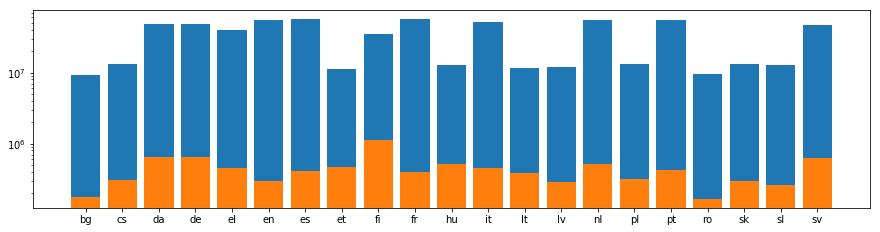

In [27]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
ax.bar(lang_labels, word_len)
ax.bar(lang_labels, uni_word_len)
plt.yscale('log')
plt.title('Number of Words vs Number of Unique Words')

##### In the above figue we can see the total number of words across all the languages and unique number of words.

Now we will check for the **Most Common** words for each language

Below we can see the Most Common Words for each language

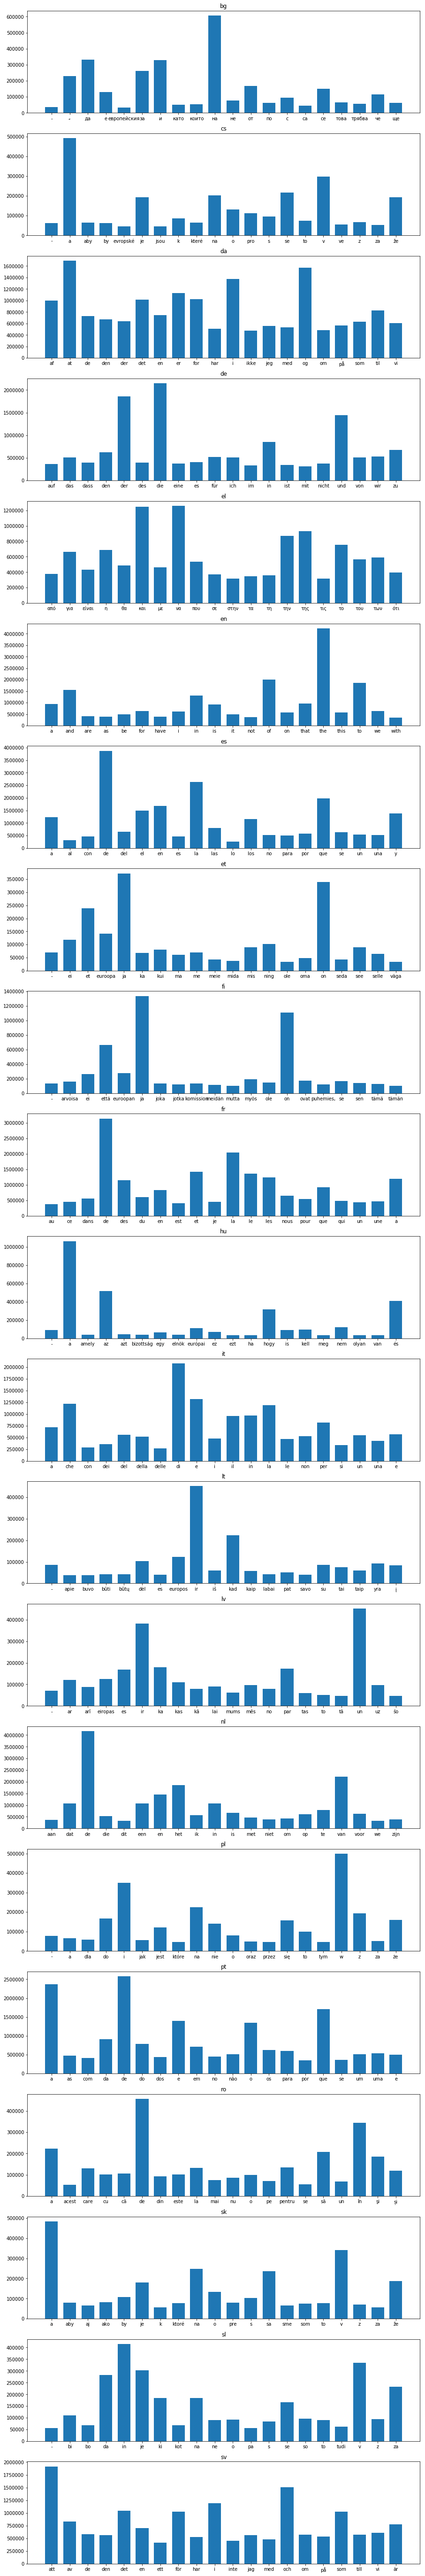

In [18]:
plt.figure(figsize=(15,100))
for ind, lang in enumerate(lang_labels):
    plt.subplot(21,1,ind+1)
    plt.title(lang)
    plt.bar([x[0] for x in most_common_words[ind][:20]], [x[1] for x in most_common_words[ind][:20]], width=0.7, align='center')

###### Now for comparison between languages we will check to see if the Most Common words between languages have any similarity.

Below we compare English and German, since English has many words with origins in German.

<Container object of 20 artists>

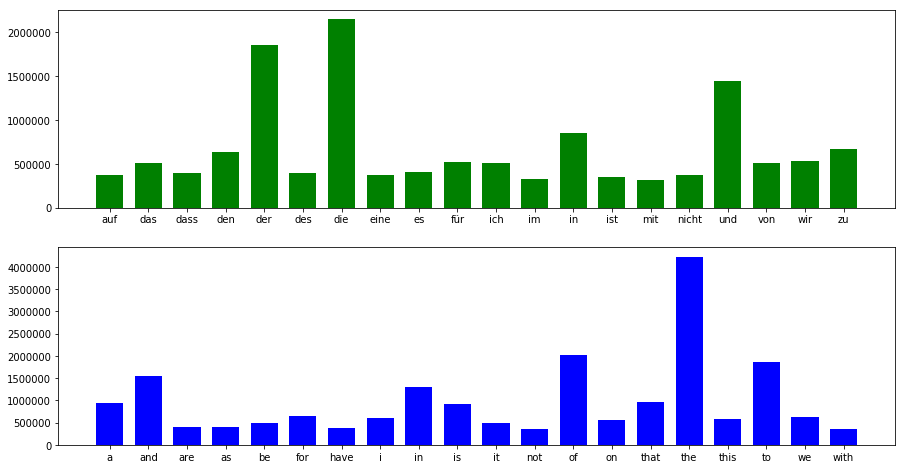

In [124]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.bar([x[0] for x in most_common_de[:20]], [x[1] for x in most_common_de[:20]], width=0.7,color='g',align='center')
plt.subplot(212)
plt.bar([x[0] for x in most_common_en[:20]], [x[1] for x in most_common_en[:20]], width=0.7,color='b',align='center')

As we can see from the above graphs that hardly any most common words are similar between each languages.

This will be a strong point to classify different languages.

**In the next notebook we will train a basic ML Model to and obtain prediction on the Test Set, to verify our model.**